In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

import sys
sys.path.insert(0, "../")

import pandas as pd
from mdu.unc.entropic_ot import EntropicOTOrdering
from mdu.unc.constants import OTTarget, ScalingType, SamplingMethod
from mdu.unc.general_metrics.mahalanobis import MahalanobisDistance

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
def make_gaussian_class(mean, cov, n):
    return rng.multivariate_normal(mean, cov, n)

def msp_uncertainty(probs):
    return 1 - probs.max(axis=1)

# def knn_distance(train_X: np.ndarray, X: np.ndarray, k: int = 10) -> np.ndarray:
#     """
#     Return distance to the k-th nearest neighbor in train_X for each row of X
#     using plain pairwise Euclidean distances and sorting.

#     Notes:
#     - If X is train_X (same object), we mask the diagonal so self-distance
#       doesn't count as a neighbor.
#     - This builds a full (len(X) x len(train_X)) matrix -> O(N*M) memory.
#     """
#     # squared Euclidean distances via (a-b)^2 = a^2 + b^2 - 2ab
#     X2 = np.sum(X**2, axis=1, keepdims=True)                 # (N, 1)
#     T2 = np.sum(train_X**2, axis=1)[None, :]                  # (1, M)
#     d2 = X2 + T2 - 2.0 * (X @ train_X.T)                      # (N, M)
#     d2 = np.maximum(d2, 0.0)                                  # numerical safety
#     D = np.sqrt(d2)

#     # If we’re querying on the training set itself, ignore self-neighbors
#     if X is train_X and D.shape[0] == D.shape[1]:
#         n = D.shape[0]
#         D[np.arange(n), np.arange(n)] = np.inf

#     # Sort each row and take the k-th smallest (1-indexed -> index k-1)
#     D_sorted = np.sort(D, axis=1)
#     kth = D_sorted[:, k-1]
#     return kth


In [3]:
n_train = 1000
n_test  = 3000
n_cal = 250

mu0 = np.array([-0.8, 0.0])
mu1 = np.array([ 0.8, 0.2])
cov = np.array([[1.0, 0.6],[0.6, 1.2]])  # correlated, overlapping

X0_tr = make_gaussian_class(mu0, cov, n_train//2)
X1_tr = make_gaussian_class(mu1, cov, n_train//2)
y_tr = np.concatenate([np.zeros(len(X0_tr), dtype=int), np.ones(len(X1_tr), dtype=int)])
X_tr = np.vstack([X0_tr, X1_tr])

X0_cal = make_gaussian_class(mu0, cov, n_cal//2)
X1_cal = make_gaussian_class(mu1, cov, n_cal//2)
y_cal = np.concatenate([np.zeros(len(X0_cal), dtype=int), np.ones(len(X1_cal), dtype=int)])
X_cal = np.vstack([X0_cal, X1_cal])

X0_te = make_gaussian_class(mu0, cov, n_test//2)
X1_te = make_gaussian_class(mu1, cov, n_test//2)
y_te = np.concatenate([np.zeros(len(X0_te), dtype=int), np.ones(len(X1_te), dtype=int)])
X_te = np.vstack([X0_te, X1_te])

In [4]:
lr = LogisticRegression()
params = lr.fit(X_tr, y_tr)
probs_te = lr.predict_proba(X_te)
probs_cal = lr.predict_proba(X_cal)

yhat_te = probs_te.argmax(axis=1)
miscl_labels = (yhat_te != y_te).astype(int)  # positives = misclassified

In [5]:
n_ood = 3000
ood_ring = make_gaussian_class(mean=np.array([0.0, 6.0]), cov=cov, n=n_ood)

In [6]:
# compute classifier probs on OOD
probs_ood = lr.predict_proba(ood_ring)

# Concatenate for OOD detection evaluation against an ID "background" sample
# Use a balanced ID sample from test set
idx_bg = rng.choice(len(X_te), size=n_ood, replace=False)
X_bg = X_te[idx_bg]
probs_bg = probs_te[idx_bg]

ood_labels = np.concatenate([np.ones(n_ood, dtype=int), np.zeros(n_ood, dtype=int)])
X_mix = np.vstack([ood_ring, X_bg])
probs_mix = np.vstack([probs_ood, probs_bg])

In [7]:
# Uncertainty measures
u1_cal = msp_uncertainty(probs_cal)
u1_te = msp_uncertainty(probs_te)
u1_mix = msp_uncertainty(probs_mix)

mah = MahalanobisDistance()
mah.fit(X_cal[None], y_cal)

u2_cal = mah.predict(X_cal[None])
u2_te = mah.predict(X_te[None])
u2_mix = mah.predict(X_mix[None])

# Evaluate AUCs
auc_miscl_u1 = roc_auc_score(y_score=u1_te, y_true=miscl_labels)
auc_miscl_u2 = roc_auc_score(y_score=u2_te, y_true=miscl_labels)

auc_ood_u1 = roc_auc_score(y_score=u1_mix, y_true=ood_labels)
auc_ood_u2 = roc_auc_score(y_score=u2_mix, y_true=ood_labels)

In [8]:
# 3) Composite via rank-max (percentile calibration on ID train)
def to_percentiles(ref, x):
    ref_sorted = np.sort(ref)
    # percentile of x within ref (empirical CDF)
    ranks = np.searchsorted(ref_sorted, x, side='right')
    return ranks / len(ref_sorted)

target = OTTarget.BETA
sampling_method = SamplingMethod.GRID
scaling_type = ScalingType.FEATURE_WISE
grid_size = 5
eps = 0.5
n_targets_multiplier = 1
max_iters = 1000
random_state = 42
tol = 1e-6


multi_dim_uncertainty = EntropicOTOrdering(
    target=target,
    sampling_method=sampling_method,
    scaling_type=scaling_type,
    grid_size=grid_size,
    target_params={},
    eps=eps,
    n_targets_multiplier=n_targets_multiplier,
    max_iters=max_iters,
    random_state=random_state,
    tol=tol,
)

scores_calib = np.column_stack([u1_cal, u2_cal])
multi_dim_uncertainty.fit(
    scores_cal=scores_calib,
)
scores_test = np.column_stack([u1_mix, u2_mix])
ood_scores = multi_dim_uncertainty.predict(scores_test)

scores_test = np.column_stack([u1_te, u2_te])
te_scores = multi_dim_uncertainty.predict(scores_test)

auc_multi_mis = roc_auc_score(y_score=te_scores, y_true=miscl_labels)
auc_multi_ood   = roc_auc_score(y_score=ood_scores, y_true=ood_labels)



# Summary table
summary = pd.DataFrame({
    "Task": ["Misclassification detection", "OOD detection"],
    "AUC: u1 (1-MSP)": [auc_miscl_u1, auc_ood_u1],
    "AUC: u2 (kNN-dist)": [auc_miscl_u2, auc_ood_u2],
    "OT-scores": [auc_multi_mis, auc_multi_ood]
})


In [9]:
summary

,Task,AUC: u1 (1-MSP),AUC: u2 (kNN-dist),OT-scores
0,Misclassification detection,0.765928,0.444899,0.710329
1,OOD detection,0.098877,0.999980,0.999883


In [ ]:
print(summary.to_latex(float_format="%.3f"))

\begin{tabular}{llrrr}
\toprule
 & Task & AUC: u1 (1-MSP) & AUC: u2 (kNN-dist) & OT-scores \\
\midrule
0 & Misclassification detection & 0.766 & 0.445 & 0.710 \\
1 & OOD detection & 0.099 & 1.000 & 1.000 \\
\bottomrule
\end{tabular}



In [10]:
import matplotlib

def pretty_matplotlib_config(fontsize=15):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams.update({'font.size': fontsize})


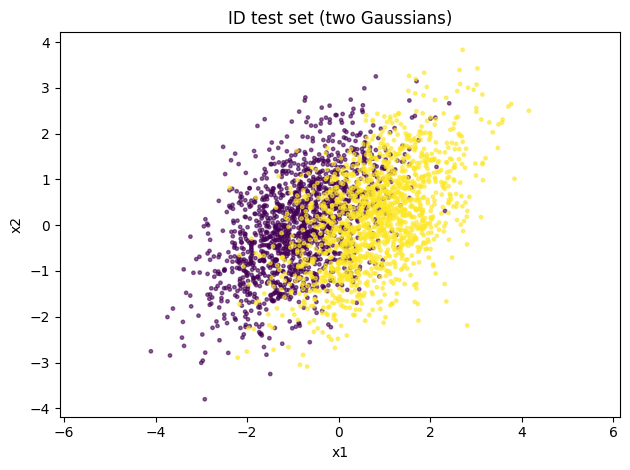

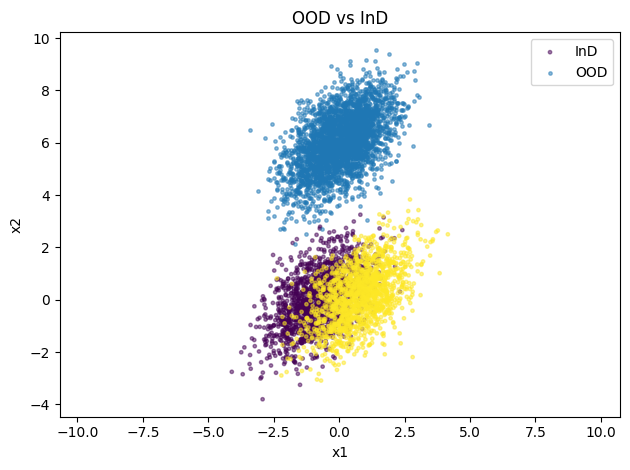

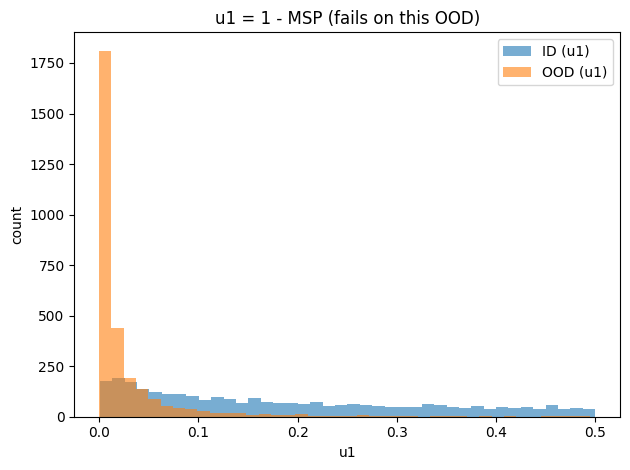

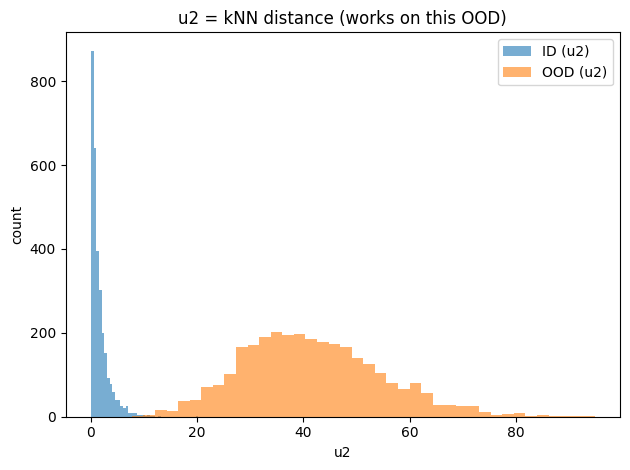

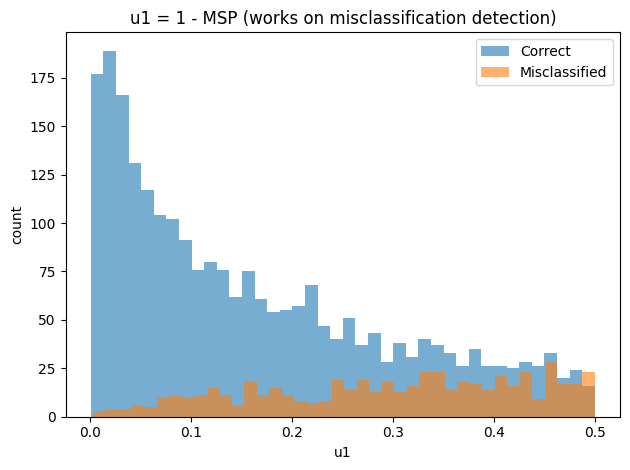

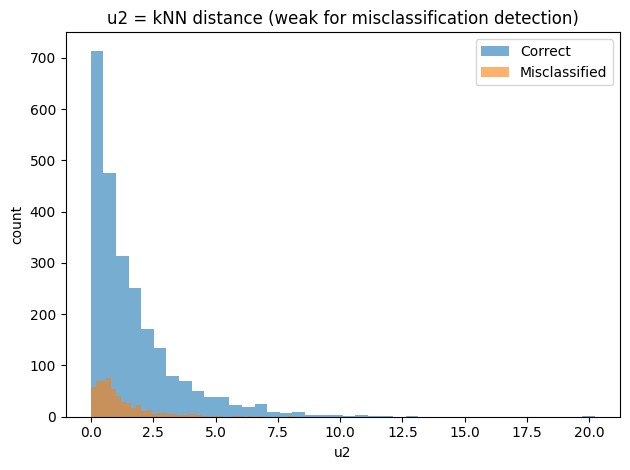

In [14]:
# Plot 1: ID test set colored by misclassification (just to see overlap)
plt.figure()
plt.scatter(X_te[:,0], X_te[:,1], s=6, alpha=0.6, label="ID test", c=y_te)
plt.title("ID test set (two Gaussians)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.axis('equal')
plt.tight_layout()
plt.savefig("second_toy_demo.pdf")
plt.show()

# Plot 2: OOD ring vs ID background
plt.figure()
plt.scatter(X_te[:,0], X_te[:,1], s=6, alpha=0.5, label="InD", c=y_te)
plt.scatter(ood_ring[:,0], ood_ring[:,1], s=6, alpha=0.5, label="OOD")
plt.legend()
plt.title("OOD vs InD")
plt.xlabel("x1"); plt.ylabel("x2")
plt.axis('equal')
plt.tight_layout()
plt.savefig("second_toy_demo_ood.pdf")
plt.show()

# Plot 3: Histograms of u1 on ID vs OOD to illustrate failure on OOD
plt.figure()
plt.hist(u1_mix[ood_labels==0], bins=40, alpha=0.6, label="ID (u1)")
plt.hist(u1_mix[ood_labels==1], bins=40, alpha=0.6, label="OOD (u1)")
plt.legend()
plt.title("u1 = 1 - MSP (fails on this OOD)")
plt.xlabel("u1"); plt.ylabel("count")
plt.tight_layout()
plt.show()

# Plot 4: Histograms of u2 on ID vs OOD (good for OOD)
plt.figure()
plt.hist(u2_mix[ood_labels==0], bins=40, alpha=0.6, label="ID (u2)")
plt.hist(u2_mix[ood_labels==1], bins=40, alpha=0.6, label="OOD (u2)")
plt.legend()
plt.title("u2 = kNN distance (works on this OOD)")
plt.xlabel("u2"); plt.ylabel("count")
plt.tight_layout()
plt.show()

# Plot 5: Histograms of u1 on correctly vs misclassified ID examples (good for misclass detection)
plt.figure()
plt.hist(u1_te[miscl_labels==0], bins=40, alpha=0.6, label="Correct")
plt.hist(u1_te[miscl_labels==1], bins=40, alpha=0.6, label="Misclassified")
plt.legend()
plt.title("u1 = 1 - MSP (works on misclassification detection)")
plt.xlabel("u1"); plt.ylabel("count")
plt.tight_layout()
plt.show()

# Plot 6: Histograms of u2 on correctly vs misclassified (poor for misclass detection)
plt.figure()
plt.hist(u2_te[miscl_labels==0], bins=40, alpha=0.6, label="Correct")
plt.hist(u2_te[miscl_labels==1], bins=40, alpha=0.6, label="Misclassified")
plt.legend()
plt.title("u2 = kNN distance (weak for misclassification detection)")
plt.xlabel("u2"); plt.ylabel("count")
plt.tight_layout()
plt.show()

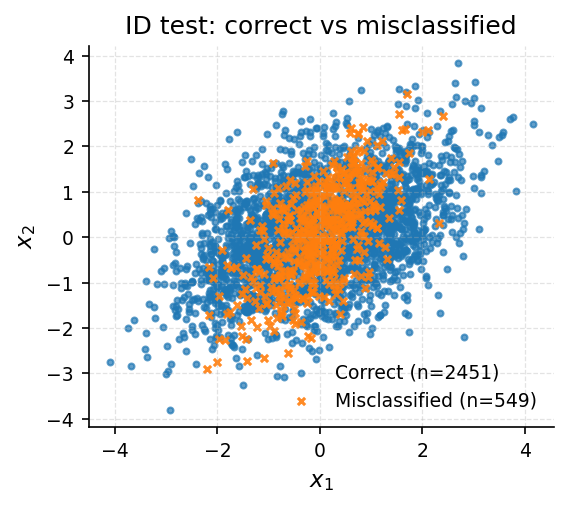

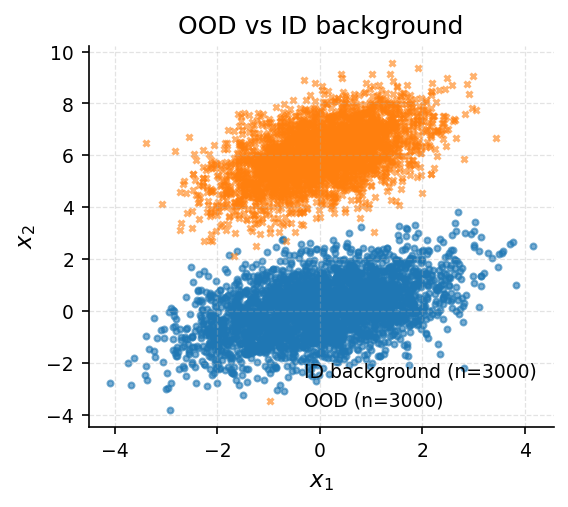

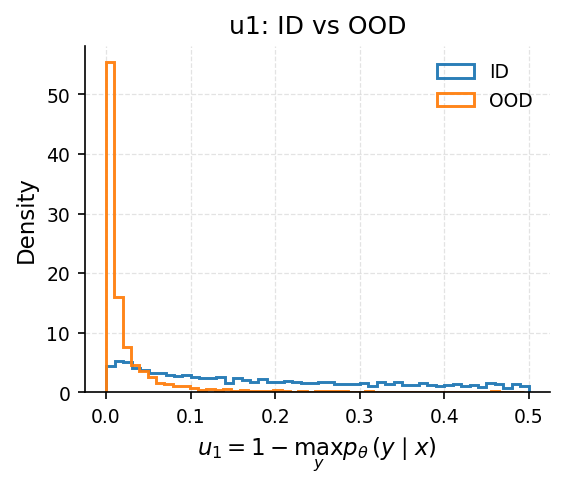

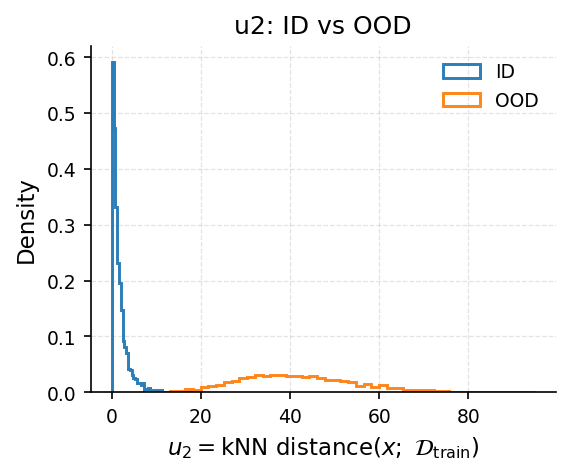

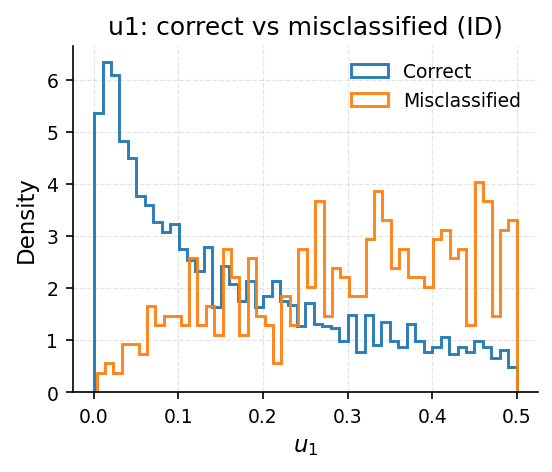

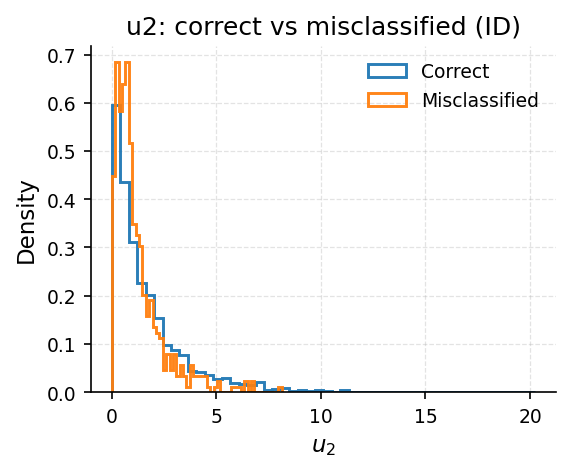

In [ ]:
# plt.rcParams.update({
#     "figure.dpi": 150,
#     "savefig.dpi": 300,
#     "font.size": 11,
#     "axes.labelsize": 11,
#     "axes.titlesize": 12,
#     "legend.fontsize": 9,
#     "xtick.labelsize": 9,
#     "ytick.labelsize": 9,
#     "axes.spines.top": False,
#     "axes.spines.right": False,
# })


# # Figure 1: ID test, correct vs misclassified
# fig1 = plt.figure(figsize=(4.0, 3.3))
# ax = plt.gca()
# mis = (miscl_labels == 1)
# cor = ~mis
# ax.scatter(X_te[cor, 0], X_te[cor, 1], s=8, alpha=0.7, marker="o", label=f"Correct (n={cor.sum()})")
# ax.scatter(X_te[mis, 0], X_te[mis, 1], s=12, alpha=0.9, marker="x", label=f"Misclassified (n={mis.sum()})")
# ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
# ax.set_title("ID test: correct vs misclassified")
# ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.35)
# ax.legend(frameon=False, loc="best")

# # Figure 2: OOD vs ID background
# fig2 = plt.figure(figsize=(4.0, 3.3))
# ax = plt.gca()
# ax.scatter(X_bg[:, 0], X_bg[:, 1], s=8, alpha=0.6, marker="o", label=f"ID background (n={len(X_bg)})")
# ax.scatter(ood_ring[:, 0], ood_ring[:, 1], s=8, alpha=0.6, marker="x", label=f"OOD (n={len(ood_ring)})")
# ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
# ax.set_title("OOD vs ID background")
# ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.35)
# ax.legend(frameon=False, loc="best")

# # Helper: step histograms
# def clean_histogram(data_list, labels, xlabel, title, bins=50, density=True):
#     fig = plt.figure(figsize=(4.0, 3.0))
#     ax = plt.gca()
#     for data, lab in zip(data_list, labels):
#         ax.hist(data, bins=bins, density=density, histtype="step", linewidth=1.4, alpha=0.95, label=lab)
#     ax.set_xlabel(xlabel); ax.set_ylabel("Density" if density else "Count")
#     ax.set_title(title)
#     ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.35)
#     ax.legend(frameon=False, loc="best")
#     return fig

# # Figure 3: u1 ID vs OOD
# fig3 = clean_histogram(
#     [u1_mix[ood_labels==0], u1_mix[ood_labels==1]],
#     ["ID", "OOD"],
#     xlabel=r"$u_1 = 1 - \max_y p_\theta(y\mid x)$",
#     title="u1: ID vs OOD"
# )

# # Figure 4: u2 ID vs OOD
# fig4 = clean_histogram(
#     [u2_mix[ood_labels==0], u2_mix[ood_labels==1]],
#     ["ID", "OOD"],
#     xlabel=r"$u_2 = \mathrm{kNN\ distance}(x;\ \mathcal{D}_{\mathrm{train}})$",
#     title="u2: ID vs OOD"
# )

# # Figure 5: u1 correct vs misclassified
# fig5 = clean_histogram(
#     [u1_te[miscl_labels==0], u1_te[miscl_labels==1]],
#     ["Correct", "Misclassified"],
#     xlabel=r"$u_1$",
#     title="u1: correct vs misclassified (ID)"
# )

# # Figure 6: u2 correct vs misclassified
# fig6 = clean_histogram(
#     [u2_te[miscl_labels==0], u2_te[miscl_labels==1]],
#     ["Correct", "Misclassified"],
#     xlabel=r"$u_2$",
#     title="u2: correct vs misclassified (ID)"
# )